In [380]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from numba import jit

In [381]:
# unpickle n_words, translation_len, votes, n_translations from data folder
with open('data/n_words.pkl', 'rb') as f:
    n_words = pickle.load(f)

with open('data/translation_len.pkl', 'rb') as f:
    translation_len = pickle.load(f)

with open('data/votes.pkl', 'rb') as f:
    votes = pickle.load(f)
    
with open('data/n_translations.pkl', 'rb') as f:
    n_translations = pickle.load(f)

with open('data/true_likes.pkl', 'rb') as f:
    true_likes = pickle.load(f)

In [382]:
def min_max_scaling_numpy(data, new_min=1, new_max=10):
    if data.size == 0:
        return data
    original_min = np.min(data)
    original_max = np.max(data)

    if original_min == original_max or new_min == new_max:
        return data
    scaled_data = ((data - original_min) / (original_max - original_min)) * (new_max - new_min) + new_min
    
    return scaled_data

In [383]:
def adjust_entropy(prob_distribution, temperature):
    temperature = max(1e-3, temperature)
    scaled_probs = np.power(prob_distribution, 1 / temperature)
    adjusted_distribution = scaled_probs / np.sum(scaled_probs)

    return adjusted_distribution

In [384]:
true_ranked = np.argsort(true_likes)[::-1]

In [385]:
n_translations

array([  32,  230, 2687, 1649,  566,  667,  576,  965,  824,  758,  867,
        896, 1200,  656,  825,  629,  742, 1810, 3247, 2632, 1509, 2272,
       3447, 1696, 2255, 1408, 1519, 1475, 2079, 1926])

In [386]:
# convert votes to numpy array of sums of lists
votes = np.array([sum(v) for v in votes.values()])
votes

array([  107,   692,  2151,  2512,  1361,  1651,  1409,  3070,  2019,
        1859,  2206,  2842,  3254,  2736,  3221,  2289,  2212,  3290,
        6156, 10378, 10622,  6171,  6928,  6097,  7073,  5222,  6818,
        7259,  8409,  9960])

In [387]:
class SlovotvirModel:

    def __init__(self, n_words, translation_len, votes, n_translations, a, b, t) -> None:
        # epoch states 
        self.n_words = n_words
        self.translation_len = translation_len
        self.votes = votes
        self.n_translations = n_translations

        # cumulative words
        self.cum_words = np.cumsum(n_words)

        # hyperparameters
        self.a = a
        self.b = b
        self.t = t

        self.words = dict()
        for i in range(sum(n_words)):
            self.words[i] = [[], []] # [[likes], [lengths]]

    
    def like_prob(self, 
                  lengths, 
                  likes):
        probs = lengths ** self.a + likes ** self.b
        return probs / probs.sum()
    
    def run_epoch(self, epoch):
        # n_words = self.n_words[epoch]
        n_translations = self.n_translations[epoch]
        votes = self.votes[epoch]
        cum_words = self.cum_words[epoch]

        # distribute n_translation into an array of length cum_words
        translation_num = np.random.multinomial(n_translations, np.ones(cum_words)/cum_words)

        # get the indices of non-zero elements in translation_num
        non_zero_indices = np.nonzero(translation_num)[0]

        # update the words list only for non-zero indices
        for i in non_zero_indices:
            n = translation_num[i]
            self.words[i][0] += [0] * n # initialize likes to 0
            self.words[i][1] += np.random.choice(self.translation_len, n).tolist() # initialize lengths to random values

        # randomly choose votes words with replacement where indices are <= cum_words such that words[i][1] is not empty
        # indices of words where words[i][1] is not empty
        indices = np.array([i for i in range(cum_words) if len(self.words[i][0]) > 0])
        cum_likes = np.array([sum(self.words[i][1]) for i in indices])
        indices = np.random.choice(indices, 
                                   size=votes, 
                                   p=adjust_entropy(cum_likes / cum_likes.sum(), temperature=self.t), replace=True)
        
        for _ in indices:
            # get the word
            likes = min_max_scaling_numpy(np.array(self.words[_][0]))
            lengths = min_max_scaling_numpy(np.array(self.words[_][1]))

            # get the probability of liking each translation
            probs = self.like_prob(lengths, likes)

            # choose a translation
            translation = np.random.choice(likes, p=probs)

            # update the number of likes for the translation
            self.words[_][0][likes.tolist().index(translation)] += 1


            
    def run(self):
        n_epochs = len(self.n_words)
        for epoch in range(n_epochs):
            self.run_epoch(epoch)

In [388]:
translation_len.max()

46

In [389]:
def run_model(a, b, t):
    model = SlovotvirModel(n_words, translation_len, votes, n_translations, a, b, t)
    model.run()
    # combine all likes list from the model
    likes = []
    for i in range(len(model.words)):
        likes += model.words[i][0]

    likes = np.array(likes)
    likes_ranked = np.argsort(likes)[::-1]
    return likes[likes_ranked]

In [390]:
likes_model = run_model(0, 10, 1)

In [391]:
int(true_likes.sum())

130394

In [392]:
int(sum(votes))

129974

In [393]:
sum(likes_model)

129974

In [394]:
sum(likes_model) / sum(true_likes)

0.9967789928984463

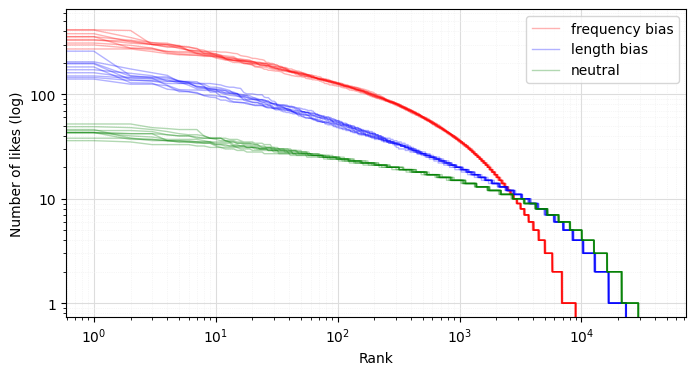

In [395]:
fig, ax = plt.subplots(figsize=(8, 4))
for _ in range(10):
        likes_model = run_model(0, 10, 0.5)
        plt.plot(range(len(likes_model)), 
                likes_model, 
                color='red', 
                linewidth=1, alpha=0.3, label = 'frequency bias')
for _ in range(10):
        likes_model = run_model(10, 0, 0.5)
        plt.plot(range(len(likes_model)), 
                likes_model, 
                color='blue', 
                linewidth=1, alpha=0.3, label='length bias')
for _ in range(10):
        likes_model = run_model(0, 0, 0.5)
        plt.plot(range(len(likes_model)), 
                likes_model, 
                color='green', 
                linewidth=1, alpha=0.3, label='neutral')
# plt.plot(range(len(true_likes)), 
#         true_likes[true_ranked], 
#         linewidth=2, color='black')
ax.set_xlabel('Rank (log scale)')
ax.set_ylabel('Number of likes')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xscale('log')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
plt.show()